## Task 3: Transfer Learning

In [20]:
import numpy as np
from tensorflow.keras.applications import ResNet50V2
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dropout, Input, Flatten, Dense, MaxPooling2D
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import keras_tuner as kt
from keras_tuner.tuners import Hyperband
import pandas as pd

from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline

In [2]:
# constants
img_height = img_width = 128
batch_size = 128
img_size = (img_height, img_width)

train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'

epochs=30


### 1. Classification Set-Up

In [3]:
np.random.seed(123)
metrics = ["accuracy"]

### 2. Setting Up the Base Model

In [4]:
# instantiate pre-trained model and freeze layers
ResNet_model = ResNet50V2(
    include_top=False,
    weights="imagenet",
)

ResNet_model.trainable = False

In [5]:
# add extra layers to model
inputs = Input(shape=(img_height, img_width, 3))
x = ResNet_model(inputs, training = False)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(32, activation = 'relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = keras.Model(
    inputs,
    outputs
)

# print architecture
model.summary(show_trainable = True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ resnet50v2 (Functional)     │ (None, 4, 4, 2048)    │ 23,564,800 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 4, 4, 2048)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 32768)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 32)            │  1,048,608 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 32)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 1)             │         33 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 24,613,441 (93.89 MB)

 Trainable params: 1,048,641 (4.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### 3. Model Training

In [6]:
# compile model and fetch training and validation data
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

train_data_gen = training_data_Pipeline(batch_size, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(batch_size, img_size, test_dir = val_dir, train_dir = train_dir)

total_train=train_data_gen.samples
total_val = val_data_gen.samples

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [7]:
# train model
history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5845 - loss: 5.6655 - val_accuracy: 0.4948 - val_loss: 0.6759
Epoch 2/30
 1/12 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5000 - loss: 0.6150

c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - accuracy: 0.5000 - loss: 0.6150 - val_accuracy: 0.4974 - val_loss: 0.6773
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5138 - loss: 0.6135 - val_accuracy: 0.5078 - val_loss: 0.6689
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - accuracy: 0.5234 - loss: 0.4944 - val_accuracy: 0.5000 - val_loss: 0.6594
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5790 - loss: 0.6516 - val_accuracy: 0.5339 - val_loss: 0.6746
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - accuracy: 0.6719 - loss: 0.5901 - val_accuracy: 0.5443 - val_loss: 0.6716
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6347 - loss: 0.6115 - val_accuracy: 0.5599 - val_loss: 0.6583
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.6406 - loss: 0.5737 - val_accuracy: 0.5599 - val_loss: 0.6569
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7144 - loss: 0.5808 - val_accuracy: 0.5651 - val_loss: 0.

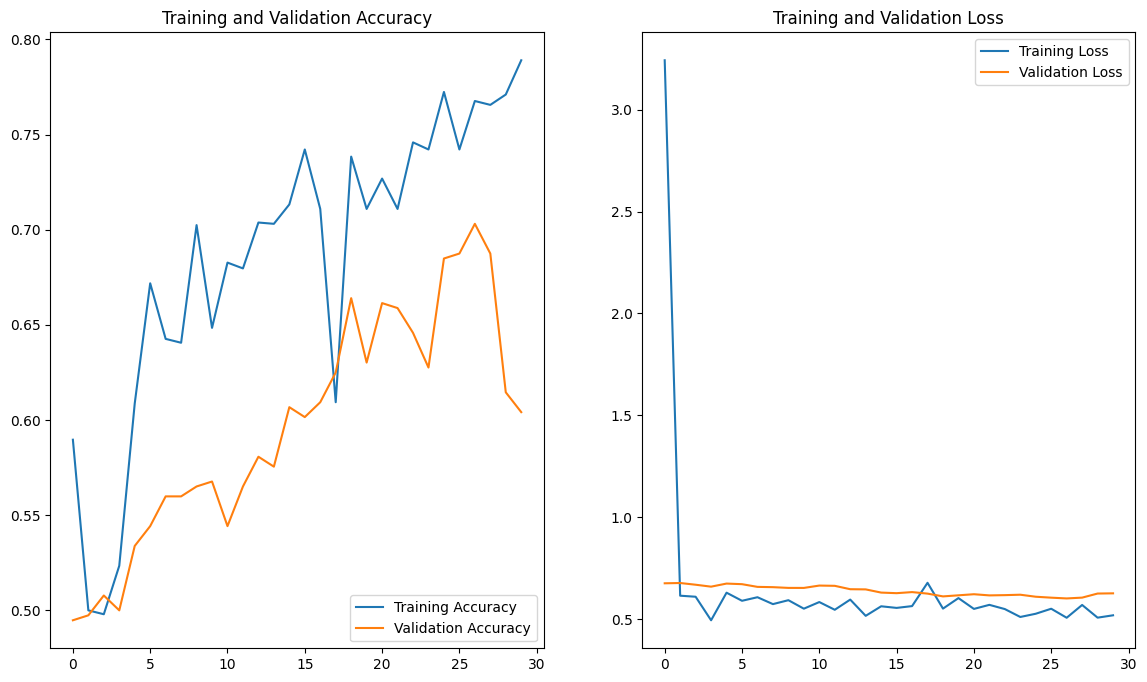

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4. Hyperparameter Tuning

In [9]:
tf.config.run_functions_eagerly(True)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tf.config.run_functions_eagerly(False)

In [10]:
inputs = Input(shape=(img_height, img_width, 3))
x = ResNet_model(inputs, training = False)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(32, activation = 'relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = keras.Model(
    inputs,
    outputs
)
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

early_history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks = [early_stop]
)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6229 - loss: 3.6088 - val_accuracy: 0.5156 - val_loss: 0.6828
Epoch 2/30
 1/12 ━━━━━━━━━━━━━━━━━━━━ 10s 961ms/step - accuracy: 0.5859 - loss: 0.6255

c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.5859 - loss: 0.6255 - val_accuracy: 0.5130 - val_loss: 0.6804
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6727 - loss: 0.5949 - val_accuracy: 0.5833 - val_loss: 0.6791
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - accuracy: 0.7031 - loss: 0.5518 - val_accuracy: 0.5859 - val_loss: 0.6716
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7308 - loss: 0.5110 - val_accuracy: 0.5391 - val_loss: 0.6612
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - accuracy: 0.7031 - loss: 0.5251 - val_accuracy: 0.5339 - val_loss: 0.6613
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7049 - loss: 0.5029 - val_accuracy: 0.6302 - val_loss: 0.6288
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.7656 - loss: 0.4631 - val_accuracy: 0.6302 - val_loss: 0.6367
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7526 - loss: 0.4615 - val_accuracy: 0.6979 - val_loss: 0.

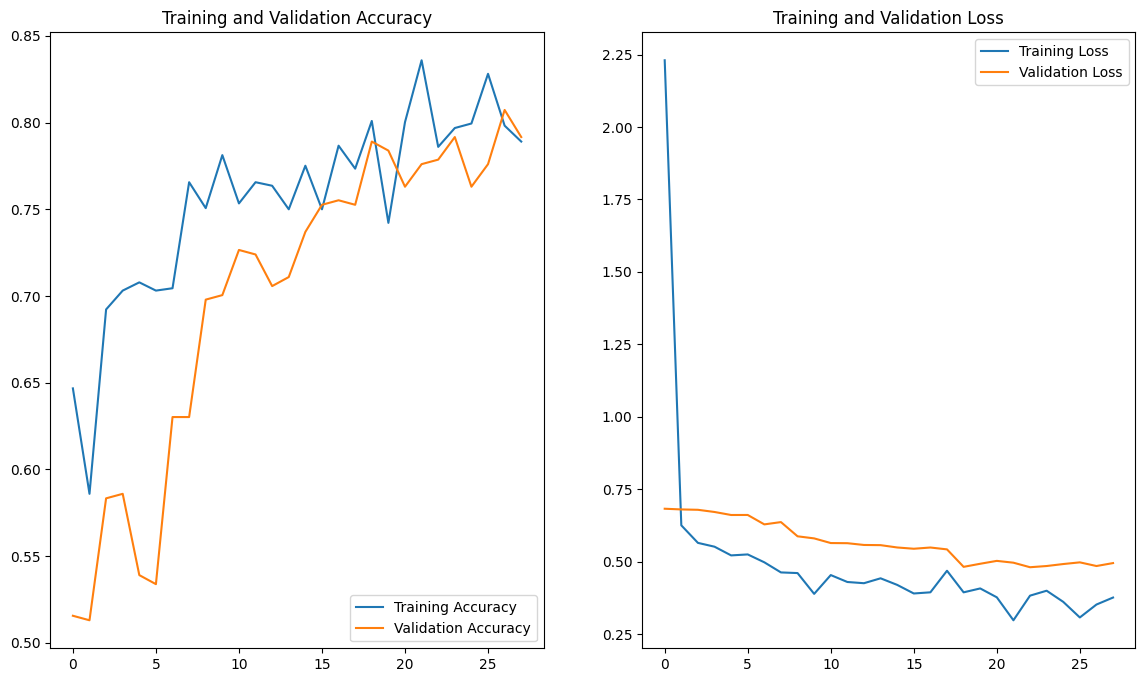

In [11]:
acc = early_history.history['accuracy']
val_acc = early_history.history['val_accuracy']

loss=early_history.history['loss']
val_loss=early_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# OPTION 1: Loop over different combinations of hyperparameters
# runs a very long time (>2h)

batch_sizes = [32, 64, 128]
learning_rates = [0.0001, 0.001, 0.01]
dropout_rates = [0.2, 0.3, 0.4]

results = []

for batch_size in batch_sizes:
    for lr in learning_rates:
        for dr in dropout_rates:
            print(f'batch size: {batch_size}, learning rate: {lr}, dropout rate: {dr}')
            inputs = Input(shape=(img_height, img_width, 3))
            x = ResNet_model(inputs, training = False)
            x = Dropout(dr)(x)
            x = Flatten()(x)
            x = Dense(32, activation = 'relu')(x)
            x = Dropout(dr)(x)
            outputs = Dense(1, activation = 'sigmoid')(x)
            model = keras.Model(
                inputs,
                outputs
            )

            optimizer = keras.optimizers.Adam(learning_rate = lr)
            model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

            # Train model
            history = model.fit(
                train_data_gen,
                batch_size=batch_size,
                steps_per_epoch=total_train // batch_size,
                epochs=epochs,
                validation_data=val_data_gen,
                validation_steps=total_val // batch_size,
                callbacks = [early_stop],
                verbose = 0
            )

            # Collect results
            best_val_acc = max(history.history['val_accuracy'])
            results.append({
                'batch_size': batch_size,
                'learning_rate': lr,
                'dropout_rate': dr,
                'val_accuracy': best_val_acc
            })

            best_val_acc = max(history.history['val_accuracy'])
            print(f"Done: batch_size={batch_size}, lr={lr}, dr={dr}, val_acc={best_val_acc:.4f}")


df = pd.DataFrame(results)
df.to_csv("hyperparameter_tuning_results_grid.csv", index=False)


batch size: 32, learning rate: 0.0001, dropout rate: 0.2
Done: batch_size=32, lr=0.0001, dr=0.2, val_acc=0.8100
batch size: 32, learning rate: 0.0001, dropout rate: 0.3
Done: batch_size=32, lr=0.0001, dr=0.3, val_acc=0.8150
batch size: 32, learning rate: 0.0001, dropout rate: 0.4
Done: batch_size=32, lr=0.0001, dr=0.4, val_acc=0.7950
batch size: 32, learning rate: 0.001, dropout rate: 0.2
Done: batch_size=32, lr=0.001, dr=0.2, val_acc=0.7975
batch size: 32, learning rate: 0.001, dropout rate: 0.3
Done: batch_size=32, lr=0.001, dr=0.3, val_acc=0.7875
batch size: 32, learning rate: 0.001, dropout rate: 0.4
Done: batch_size=32, lr=0.001, dr=0.4, val_acc=0.8000
batch size: 32, learning rate: 0.01, dropout rate: 0.2
Done: batch_size=32, lr=0.01, dr=0.2, val_acc=0.5425
batch size: 32, learning rate: 0.01, dropout rate: 0.3
Done: batch_size=32, lr=0.01, dr=0.3, val_acc=0.5675
batch size: 32, learning rate: 0.01, dropout rate: 0.4
Done: batch_size=32, lr=0.01, dr=0.4, val_acc=0.7275
batch size

In [14]:
# OPTION 2: Hyperparameter tuning with keras-tuner
# runs for >2h
results = []

def build_model(hp):
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.05)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')

    inputs = Input(shape=(img_height, img_width, 3))
    x = ResNet_model(inputs, training = False)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)
    x = Dense(32, activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = keras.Model(
        inputs,
        outputs
    )

    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

    return model


for batch_size in [32, 64, 128]:
    tuner = Hyperband(
        build_model,
        objective='val_accuracy',
        max_epochs=10,
        factor=3,
        directory='tuner_results',
        project_name=f'resnet_tuning_{batch_size}'
    )


    tuner.search(
        train_data_gen,
        batch_size=batch_size,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size,
        callbacks = [early_stop]
    )

    best_hp = tuner.get_best_hyperparameters(1)[0]
    best_val_acc = tuner.get_best_models(1)[0].evaluate(val_data_gen, verbose=0)[1]

    results.append({
        'batch_size': batch_size,
        'learning_rate': best_hp.get('learning_rate'),
        'dropout_rate': best_hp.get('dropout_rate'),
        'val_accuracy': best_val_acc
    })

df = pd.DataFrame(results)
df.to_csv("hyperparameter_tuning_results_keras-tuner.csv", index=False)


Trial 30 Complete [00h 03m 18s]
val_accuracy: 0.6953125

Best val_accuracy So Far: 0.7708333134651184
Total elapsed time: 00h 41m 53s


### 5. Train your pre-trained model

In [15]:
full_data_gen = training_data_Pipeline(128, img_size, 'covid xray/train_val')

# ADD OPTIMAL PARAMETERS
batch_size = 64
learning_rate = 0.0001
dropout_rate = 0.3

inputs = Input(shape=(img_height, img_width, 3))
x = ResNet_model(inputs, training = False)
x = Dropout(dropout_rate)(x)
x = Flatten()(x)
x = Dense(32, activation = 'relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = keras.Model(
    inputs,
    outputs
)

optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

history = model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs
)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6172 - loss: 1.8436
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7245 - loss: 0.5849
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7379 - loss: 0.5410
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7574 - loss: 0.5056
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7690 - loss: 0.4619
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7724 - loss: 0.4555
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7815 - loss: 0.4308
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7973 - loss: 0.4129
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8085 - loss: 0.4310
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8163 - loss: 0.3866
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8157 - loss: 0.3838
Epoch 12/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8361 - lo

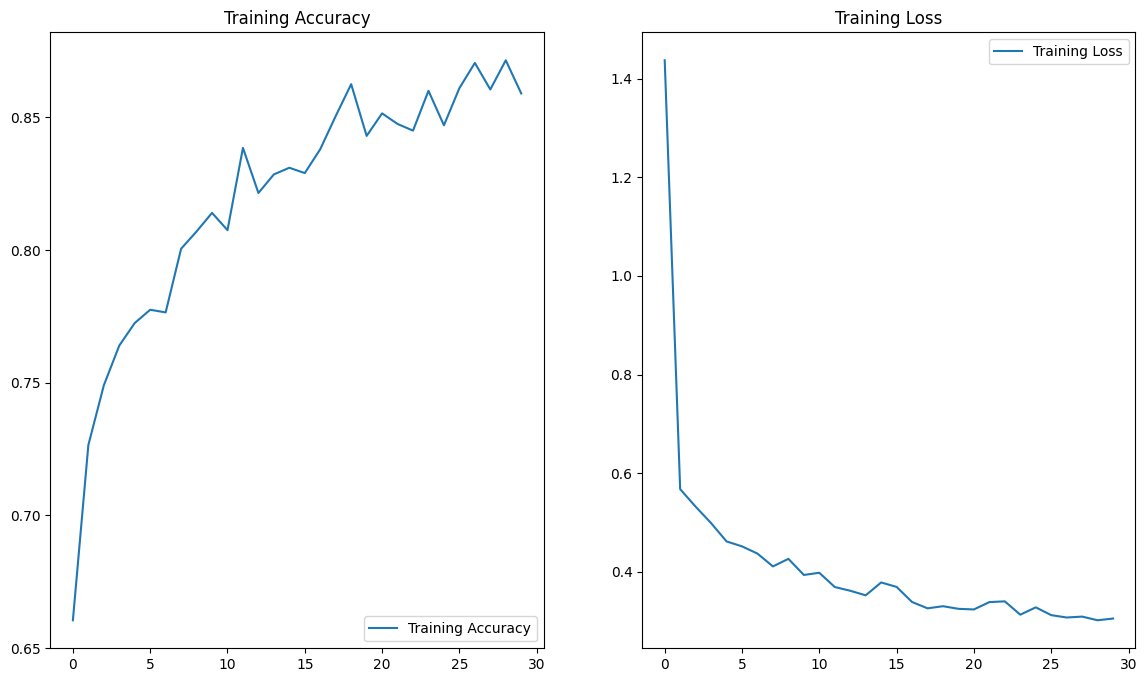

In [16]:
acc = history.history['accuracy']
loss=history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [17]:
model.save("ResNet_model.h5")
loaded_model = load_model("ResNet_model.h5")

### 6. Fine-tuning of the entire model

In [ ]:
# do fine-tuning part
model.save("ResNet_final_model.h5")

In [ ]:
final_model = load_model("ResNet_final_model.h5")

In [18]:
final_model = load_model("ResNet_model.h5")

In [21]:
test_data_gen = test_validation_data_Pipeline(batch_size, img_size, 'covid xray/train_val', test_dir)
loss, accuracy = final_model.evaluate(test_data_gen)

y_true = test_data_gen.classes
y_pred_probs = final_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(y_true, y_pred, target_names=test_data_gen.class_indices.keys()))

Found 2000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 896ms/step - accuracy: 0.8191 - loss: 0.3943
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 876ms/step
Test Loss: 0.3851
Test Accuracy: 0.8200
              precision    recall  f1-score   support

       COVID       0.52      0.45      0.48       100
      NORMAL       0.52      0.59      0.55       100

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.52      0.52      0.52       200



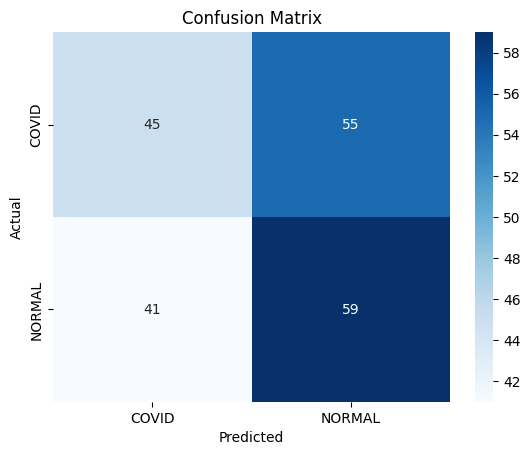

In [22]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data_gen.class_indices.keys(), yticklabels=test_data_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Plot a few samples from the test dataset (without pre-processing) with their evaluations(after pre-processing).